### Test 1: Apply random forest classifier to features calculated on a per-file basis

In [2]:
import pandas as pd
import obspy as op
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
all_data = pd.read_csv("Fnames_soilM_temp.csv")
lineCSN = all_data[all_data['Line'] == "LineCSN"]

#Extract just the soil moisture time series corresponding to probe M3_20
lineCSN_M3 = lineCSN[['file_name','DateTime','M3_20_Avg_interp','Temphigh_interp']]
lineCSN_M3.reset_index(drop=True,inplace=True)
lineCSN_M3.assign(DateTime = pd.to_datetime(lineCSN_M3['DateTime']))
lineCSN_M3.set_index('DateTime',inplace=True)


In [6]:
#Generate linking column
lineCSN_M3 = lineCSN_M3.assign(file_name=lineCSN_M3['file_name'].apply(lambda x: x[2:]))

In [7]:
lineCSN_M3.head()

,file_name,M3_20_Avg_interp,Temphigh_interp
DateTime,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156


Load the feature dfs we just made

In [8]:
mean = pd.read_csv('mean.csv')
mean.name = "mean"
median = pd.read_csv('median.csv')
median.name = "median"
energy = pd.read_csv('energy.csv')
energy.name = "energy"
iqr = pd.read_csv('iqr.csv')
iqr.name = "iqr"
kurtosis = pd.read_csv('kurtosis.csv')
kurtosis.name = "kurtosis"
rms = pd.read_csv('rms.csv')
rms.name = "rms"
skew = pd.read_csv('skew.csv')
skew.name = "skew"
sma_1_comp = pd.read_csv('sma_1_comp.csv')
sma_1_comp.name = "sma_1_omp"
std = pd.read_csv('std.csv')
std.name = "std"
Z = pd.read_csv('Z.csv')
Z.name = "Z"
variance = pd.read_csv('variance.csv')
variance.name = "var"
xcrossing = pd.read_csv('xcrossing_rate.csv')
xcrossing.name = "xcrossing_rate"
minmax = pd.read_csv('minmax.csv')
minmax.name = "minmax"
mad = pd.read_csv('mad.csv')
mad.name = "mad"
cav = pd.read_csv('cav.csv')
cav.name = "cav"

In [9]:
features = [mean,median,cav,Z,energy,skew,rms,mad,sma_1_comp,std,variance,xcrossing,minmax,iqr,kurtosis]

An example of a feature dataframe

In [10]:
mean.head()

,channel_75,channel_76,channel_77,channel_78,channel_79,channel_80,channel_81,channel_82,channel_83,channel_84,...,channel_86,channel_87,channel_88,channel_89,channel_90,channel_91,channel_92,channel_93,channel_94,file_name
0,11.681328,11.297560,10.565713,10.651578,9.927648,10.649434,11.528420,12.121641,12.656151,15.255091,...,16.723557,17.106794,17.401350,18.916747,17.739294,18.236246,18.532227,14.985069,14.814697,20160805180738_40_Hz_LineCSN.mseed
1,11.566667,11.367564,10.293708,10.528026,10.187237,10.394019,10.176871,11.829739,12.520605,13.665388,...,15.142217,15.262201,15.716973,17.121646,15.819953,16.022636,19.865663,16.466882,15.095997,20160805180838_40_Hz_LineCSN.mseed
2,17.457526,16.757426,14.713631,15.279337,15.348863,15.728186,16.027678,17.240832,18.369659,19.865462,...,23.811905,24.183990,23.955821,27.518926,22.556312,23.323985,24.246977,23.410367,20.746625,20160805180938_40_Hz_LineCSN.mseed
3,22.503722,19.208751,17.648510,18.175225,18.467215,18.466986,19.151163,21.811650,22.420826,23.606734,...,28.118455,28.151359,24.944283,24.831824,22.715120,24.763001,25.123822,24.214795,21.177069,20160805181038_40_Hz_LineCSN.mseed
4,7.909541,7.508461,6.932315,7.417068,7.180079,7.608237,7.936308,9.298768,9.420749,9.748277,...,10.862061,10.854751,9.860103,9.708139,9.775488,10.243657,10.200908,9.650366,8.944905,20160805181138_40_Hz_LineCSN.mseed


### Testing merge ability

In [22]:
def extract_mean_over_channels(indf):
    
    newcolname = "mean_%s" %indf.name
    opdf = indf[['file_name']]
    opdf = opdf.assign(mean_col = indf.drop('file_name',axis=1).mean(axis=1))
    opdf.columns = ['file_name',newcolname]
    
    return opdf

In [23]:
m1 = extract_mean_over_channels(mean)
m1.head()

,file_name,mean_mean
0,20160805180738_40_Hz_LineCSN.mseed,14.361770
1,20160805180838_40_Hz_LineCSN.mseed,13.701386
2,20160805180938_40_Hz_LineCSN.mseed,20.205624
3,20160805181038_40_Hz_LineCSN.mseed,22.655810
4,20160805181138_40_Hz_LineCSN.mseed,9.052441


In [24]:
indf = lineCSN_M3
for feature_df in features:
    
    mean_feature = extract_mean_over_channels(feature_df)
    merged_df = pd.merge(indf,mean_feature,on='file_name')
    indf = merged_df

In [25]:
merged_df.head()

,file_name,M3_20_Avg_interp,Temphigh_interp,mean_mean,mean_median,mean_cav,mean_Z,mean_energy,mean_skew,mean_rms,mean_mad,mean_sma_1_omp,mean_std,mean_var,mean_xcrossing_rate,mean_minmax,mean_iqr,mean_kurtosis
0,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489,14.361770,8.309841,861.647286,0.446708,1.338238e+06,2.851846,0.470759,3.426352,861.647286,18.029467,341.555477,1226.15,150.839529,13.717603,10.819143
1,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656,13.701386,6.213150,821.345942,0.404207,1.937958e+06,4.377103,0.570359,3.627463,821.345942,24.327355,611.562809,1258.00,248.077050,9.952303,24.638108
2,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822,20.205624,12.393668,1211.619954,0.500408,3.119695e+06,5.666495,0.717259,3.993771,1211.619954,28.717980,875.824013,1243.00,446.195626,18.797455,56.579966
3,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989,22.655810,13.747387,1359.193771,0.354066,3.047592e+06,2.911729,0.719105,4.269980,1359.193771,26.964447,745.507721,1316.50,268.897080,24.549586,13.650838
4,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156,9.052441,5.527184,543.045438,0.710345,4.471846e+05,2.155085,0.275294,2.668708,543.045438,9.993083,102.746092,1252.15,78.910585,9.537744,5.977357


In [26]:
merged_df.index = lineCSN_M3.index

In [27]:
merged_df.head(10)

,file_name,M3_20_Avg_interp,Temphigh_interp,mean_mean,mean_median,mean_cav,mean_Z,mean_energy,mean_skew,mean_rms,mean_mad,mean_sma_1_omp,mean_std,mean_var,mean_xcrossing_rate,mean_minmax,mean_iqr,mean_kurtosis
DateTime,,,,,,,,,,,,,,,,,,
2016-08-05 18:07:38,20160805180738_40_Hz_LineCSN.mseed,0.202000,27.437489,14.361770,8.309841,861.647286,0.446708,1.338238e+06,2.851846,0.470759,3.426352,861.647286,18.029467,341.555477,1226.15,150.839529,13.717603,10.819143
2016-08-05 18:08:38,20160805180838_40_Hz_LineCSN.mseed,0.202000,27.423656,13.701386,6.213150,821.345942,0.404207,1.937958e+06,4.377103,0.570359,3.627463,821.345942,24.327355,611.562809,1258.00,248.077050,9.952303,24.638108
2016-08-05 18:09:38,20160805180938_40_Hz_LineCSN.mseed,0.202013,27.409822,20.205624,12.393668,1211.619954,0.500408,3.119695e+06,5.666495,0.717259,3.993771,1211.619954,28.717980,875.824013,1243.00,446.195626,18.797455,56.579966
2016-08-05 18:10:38,20160805181038_40_Hz_LineCSN.mseed,0.202113,27.395989,22.655810,13.747387,1359.193771,0.354066,3.047592e+06,2.911729,0.719105,4.269980,1359.193771,26.964447,745.507721,1316.50,268.897080,24.549586,13.650838
2016-08-05 18:11:38,20160805181138_40_Hz_LineCSN.mseed,0.202213,27.382156,9.052441,5.527184,543.045438,0.710345,4.471846e+05,2.155085,0.275294,2.668708,543.045438,9.993083,102.746092,1252.15,78.910585,9.537744,5.977357
2016-08-05 18:12:38,20160805181238_40_Hz_LineCSN.mseed,0.202313,27.368322,8.627466,5.499426,517.405159,0.844500,4.131829e+05,2.435125,0.262419,2.563802,517.405159,9.524195,94.674329,1242.55,81.792978,8.707979,8.419048
2016-08-05 18:13:38,20160805181338_40_Hz_LineCSN.mseed,0.202413,27.354489,26.460252,14.703773,1587.489450,0.257395,4.403811e+06,2.809590,0.862578,4.713052,1587.489450,32.933261,1119.715728,1214.15,307.233676,28.677278,11.763342
2016-08-05 18:14:38,20160805181438_40_Hz_LineCSN.mseed,0.202513,27.340656,16.519360,8.692209,991.100540,0.382212,1.781066e+06,2.700716,0.545073,3.777695,991.100540,20.967610,459.704164,1255.00,183.181363,18.065695,10.654987
2016-08-05 18:15:38,20160805181538_40_Hz_LineCSN.mseed,0.202613,27.326822,44.295320,18.708027,2657.347432,0.114965,1.824516e+07,3.528740,1.760777,6.600293,2657.347432,74.011403,5595.136678,1175.55,679.688776,35.739100,15.274357


### Plotting: Example of one of the features (maen)
Clearly there is a day/night pattern here, but there is also alot of noise and spikes 

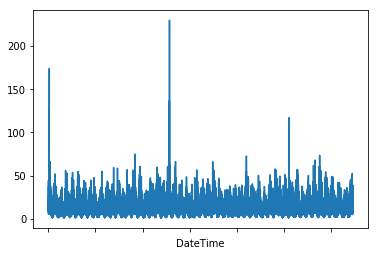

In [30]:
merged_df['mean_mean'].plot()

### Plotting: The soil moisture timeseries that we hope to predict

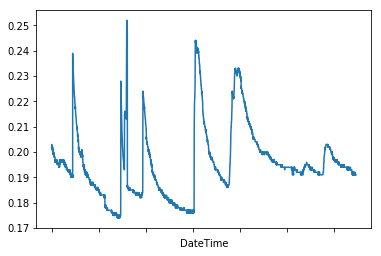

In [28]:
merged_df['M3_20_Avg_interp'].plot()

### Plotting: The temperature timseries that we hope to predict

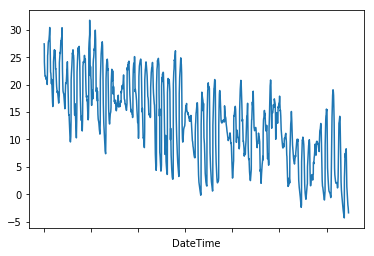

In [29]:
merged_df['Temphigh_interp'].plot()

### We could filter the feature datasets, but lets start just by trying to predict the timeseries with an RF Regressor 

In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split 

Test 1: Predict the soil moisture data

 > Min_samples_leaf should be quite high to combat noisei in the data   
 
 > Fitting takes quite a long time (5 mins or so for n_estimators=300)

In [48]:
cleaned_df = merged_df.dropna()
y = cleaned_df['M3_20_Avg_interp']
X = cleaned_df.drop(['file_name','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [50]:
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=100,oob_score=True,n_jobs=2)

In [51]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=100, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [52]:
print(regr.feature_importances_)

[0.01659608 0.11255544 0.01320358 0.09403871 0.05739097 0.05351103
 0.03110954 0.06985594 0.01283306 0.0432213  0.05812096 0.2230024
 0.09146388 0.06642841 0.0566687 ]


In [54]:
print(regr.oob_score_) 

0.024005118823644978


This training set score is really low!

In [55]:
regr_pred = regr.predict(X_test)

In [56]:
regr.score(X_test,y_test)

0.021866098507284604

Text(0,0.5,'Actual')

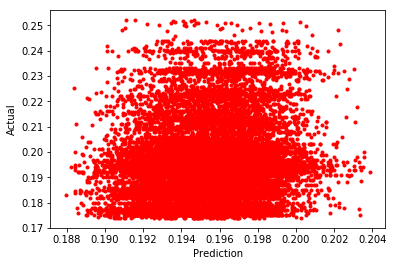

In [61]:
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Actual')

Test 2: Predict the temperature data with the same technique 

In [62]:
y = cleaned_df['Temphigh_interp']
X = cleaned_df.drop(['file_name','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [71]:
regr = RandomForestRegressor(n_estimators=300,min_samples_leaf=200,oob_score=True,n_jobs=2)

In [72]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=200, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=300, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [66]:
print(regr.feature_importances_)

[0.00902105 0.14548734 0.00713849 0.04408844 0.0115088  0.08608296
 0.01119983 0.01865023 0.0074936  0.01465641 0.01787312 0.50565763
 0.03520804 0.04358857 0.0423455 ]


In [67]:
print(regr.oob_score_) 

0.10096682561989756


In [68]:
regr_pred = regr.predict(X_test)

In [69]:
regr.score(X_test,y_test)

0.10284688940097009

Text(0,0.5,'Actual')

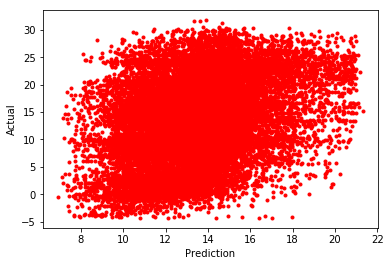

In [70]:
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Actual')

There is definity a temperature-related signal in the features

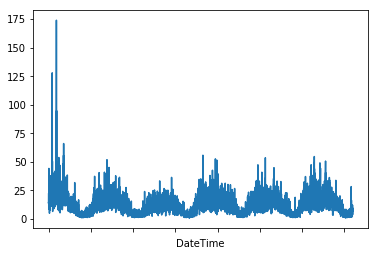

In [73]:
cleaned_df['mean_mean'][:7200].plot()

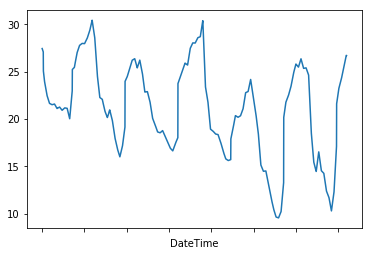

In [74]:
cleaned_df['Temphigh_interp'][:7200].plot()

### Perhaps filtering the the feature timeseries will produce a better fit

In [75]:
from scipy.signal import butter, lfilter

In [78]:
def butter_lowpass(cutoff,fs,order=4):
    nyq = 0.5*fs
    normal_cutoff = cutoff/nyq
    b, a = butter(order,normal_cutoff,btype='low')
    return b,a

def butter_lowpass_filter(data,cutoff,fs,order=4):
    b,a = butter_lowpass(cutoff,fs,order=order)
    y = lfilter(b,a,data)
    return y


Test this filter 

In [85]:
fs = 0.0167 #sampling every minute
cutoff = 0.0001 #we want to smooth the ts 
y = butter_lowpass_filter(cleaned_df['mean_mean'][:7200].values,cutoff,fs)

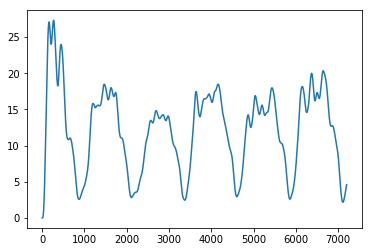

In [86]:
plt.plot(y)

In [94]:
filtered_df = pd.DataFrame()
filtered_df['file_name'] = cleaned_df['file_name']
filtered_df['M3_20_Avg_interp'] = cleaned_df['M3_20_Avg_interp']
filtered_df['Temphigh_interp'] = cleaned_df['Temphigh_interp']

for column in cleaned_df.columns[3:]:
    cname = str(column)
    filtered_df[cname] = butter_lowpass_filter(cleaned_df[cname].values,cutoff,fs)

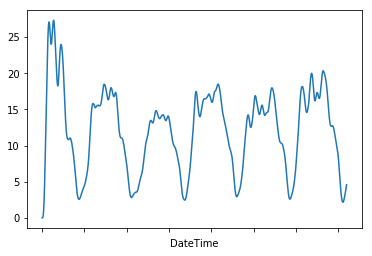

In [95]:
filtered_df['mean_mean'][:7200].plot()

### Lets try rerunning the classifier on the filtered feature timeseries

In [96]:
y = filtered_df['Temphigh_interp']
X = filtered_df.drop(['file_name','M3_20_Avg_interp','Temphigh_interp'],axis=1)

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)

In [119]:
regr = RandomForestRegressor(n_estimators=500,min_samples_leaf=10,oob_score=True,n_jobs=2)

In [120]:
regr.fit(X_train,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=10, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=2,
           oob_score=True, random_state=None, verbose=0, warm_start=False)

In [121]:
print(regr.feature_importances_)

[0.00547543 0.08444511 0.00532197 0.09938517 0.03404239 0.10181425
 0.01118823 0.02653223 0.00548775 0.02113885 0.06312407 0.34521452
 0.05745579 0.03183708 0.10753716]


In [122]:
print(regr.oob_score_) 

0.9123740395524228


In [123]:
regr_pred = regr.predict(X_test)

In [124]:
regr.score(X_test,y_test)

0.9133734027064158

Text(0,0.5,'Actual')

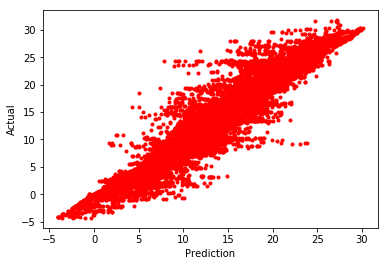

In [125]:
plt.plot(regr_pred,y_test,'r.')
plt.xlabel('Prediction')
plt.ylabel('Actual')

A better result! This suggests that noise removal will be important
This fit does not seem to improve was we increase n_estimators from 300 to 500
Since the temperature is constant over the DAS array, this suggests we could take data from another area, apply this model and get a decent result too. Maybe abolity to predict temperature is affected by other factors